### Import necessary libraries

In [43]:
import matplotlib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from skimage import transform
from skimage import exposure
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import os
import cv2
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import imutils

### Preprocess data

In [16]:
def load_split(csvPath):
    dataPath='C:/Users/ASUS/Desktop/TFS Foundation Tasks/Computer vision/data signe'
    data = []
    labels = []
    rows = open(csvPath).read().strip().split("\n")[1:]
    random.shuffle(rows)
    for (i, row) in enumerate(rows):
        if i > 0 and i % 1000 == 0:
            print("[INFO] processed {} total images".format(i))
        (label, imagePath) = row.strip().split(",")[-2:]

        imagePath = os.path.sep.join([dataPath, imagePath])
        image = io.imread(imagePath)
        image = transform.resize(image, (32, 32))
        image = exposure.equalize_adapthist(image, clip_limit=0.1)
        data.append(image)
        labels.append(int(label))
    data = np.array(data)
    labels = np.array(labels)
    return (data,labels)

In [13]:
# load the label names
labelNames = open("traffic_signs.csv").read().strip().split("\n")[1:]
labelNames = [l.split(",")[1] for l in labelNames]
print('labelNames',labelNames)

labelNames ['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'No passing', 'No passing veh over 3.5 tons', 'Right-of-way at intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles', 'Veh > 3.5 tons prohibited', 'No entry', 'General caution', 'Dangerous curve left', 'Dangerous curve right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 'End speed + passing limits', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 'End of no passing', 'End no passing veh > 3.5 tons']


In [31]:
trainPath = os.path.sep.join([dataPath, "Train.csv"])
testPath = os.path.sep.join([dataPath, "Test.csv"])
# load the training and testing data
print("[INFO] loading training and testing data...")
(trainX1, trainY1) = load_split(trainPath)
(testX1, testY1) = load_split(testPath)

print('trainX',trainX)
print('trainy',trainY)
trainX = trainX1.astype("float32") / 255.0
testX = testX1.astype("float32") / 255.0
# one-hot encode the training and testing labels
numLabels = len(np.unique(trainY1))
trainY = to_categorical(trainY1, numLabels)
testY = to_categorical(testY1, numLabels)
print('train',trainY)

# initialize a dictionary to store the class weights
classTotals = trainY.sum(axis=0)
classWeight = dict()
# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
    classWeight[i] = classTotals.max() / classTotals[i]

[INFO] loading training and testing data...
[INFO] processed 1000 total images
[INFO] processed 2000 total images
[INFO] processed 3000 total images
[INFO] processed 4000 total images
[INFO] processed 5000 total images
[INFO] processed 6000 total images
[INFO] processed 7000 total images
[INFO] processed 8000 total images
[INFO] processed 9000 total images
[INFO] processed 10000 total images
[INFO] processed 11000 total images
[INFO] processed 12000 total images
[INFO] processed 13000 total images
[INFO] processed 14000 total images
[INFO] processed 15000 total images
[INFO] processed 16000 total images
[INFO] processed 17000 total images
[INFO] processed 18000 total images
[INFO] processed 19000 total images
[INFO] processed 20000 total images
[INFO] processed 21000 total images
[INFO] processed 22000 total images
[INFO] processed 23000 total images
[INFO] processed 24000 total images
[INFO] processed 25000 total images
[INFO] processed 26000 total images
[INFO] processed 27000 total 

train [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


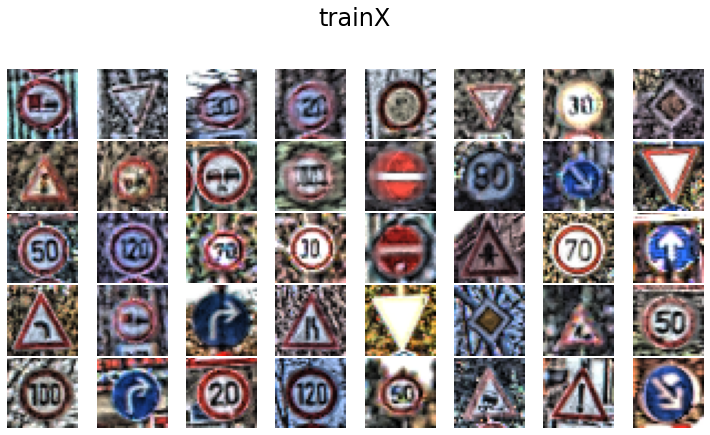

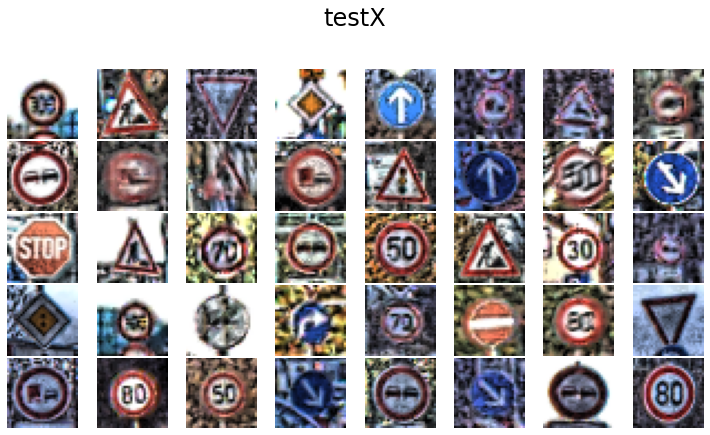

In [33]:
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(trainX1, 'trainX')
plot_images(testX1, 'testX')

### Build the model

In [34]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation='softmax')) # 43 classes for traffic signs
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

In [35]:
# Visualize Model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 2, 2, 128)       

In [36]:
history=model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY))


Epoch 1/10
1226/1226 [==============================] - 63s 50ms/step - loss: 3.5205 - accuracy: 0.0549 - val_loss: 3.4685 - val_accuracy: 0.0570
Epoch 2/10
1226/1226 [==============================] - 60s 49ms/step - loss: 3.0115 - accuracy: 0.1639 - val_loss: 1.8522 - val_accuracy: 0.4466
Epoch 3/10
1226/1226 [==============================] - 60s 49ms/step - loss: 1.6185 - accuracy: 0.4965 - val_loss: 1.1022 - val_accuracy: 0.6740
Epoch 4/10
1226/1226 [==============================] - 60s 49ms/step - loss: 1.1093 - accuracy: 0.6489 - val_loss: 0.7835 - val_accuracy: 0.7788
Epoch 5/10
1226/1226 [==============================] - 60s 49ms/step - loss: 0.8426 - accuracy: 0.7313 - val_loss: 0.6085 - val_accuracy: 0.8276
Epoch 6/10
1226/1226 [==============================] - 53s 43ms/step - loss: 0.6765 - accuracy: 0.7805 - val_loss: 0.5077 - val_accuracy: 0.8554
Epoch 7/10
1226/1226 [==============================] - 33s 27ms/step - loss: 0.5781 - accuracy: 0.8141 - val_loss: 0.4442 -

In [37]:
test_loss, test_acc = model.evaluate(testX, testY)
print('Test accuracy:', test_acc)

395/395 [==============================] - 5s 12ms/step - loss: 0.3519 - accuracy: 0.8996
Test accuracy: 0.8996041417121887


### evaluating

In [38]:
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
    predictions.argmax(axis=1), target_names=labelNames))

395/395 [==============================] - 4s 11ms/step
                               precision    recall  f1-score   support

         Speed limit (20km/h)       0.74      0.70      0.72        60
         Speed limit (30km/h)       0.86      0.96      0.91       720
         Speed limit (50km/h)       0.95      0.91      0.93       750
         Speed limit (60km/h)       0.84      0.93      0.88       450
         Speed limit (70km/h)       0.96      0.95      0.95       660
         Speed limit (80km/h)       0.85      0.82      0.83       630
  End of speed limit (80km/h)       0.99      0.83      0.91       150
        Speed limit (100km/h)       0.94      0.70      0.80       450
        Speed limit (120km/h)       0.78      0.93      0.85       450
                   No passing       0.91      0.97      0.94       480
 No passing veh over 3.5 tons       0.99      0.93      0.96       660
 Right-of-way at intersection       0.90      0.82      0.86       420
                Prio

### Plots

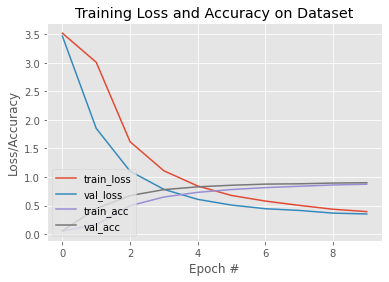

In [40]:
N = np.arange(0, 10)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, history.history["loss"], label="train_loss")
plt.plot(N, history.history["val_loss"], label="val_loss")
plt.plot(N, history.history["accuracy"], label="train_acc")
plt.plot(N, history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plots")

### Exemples

1/1 [==============================] - 0s 21ms/step


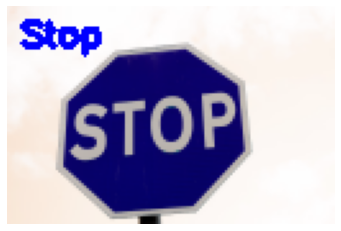

In [49]:
imagePath = "image signe.jpg"
image = io.imread(imagePath)
image = transform.resize(image, (32, 32))
image = exposure.equalize_adapthist(image, clip_limit=0.1)
image = image.astype("float32") / 255.0
image = np.expand_dims(image, axis=0)
preds = model.predict(image)
j = preds.argmax(axis=1)[0]
label = labelNames[j]
image = cv2.imread(imagePath)
image = imutils.resize(image, width=128)
cv2.putText(image, label, (5, 15), cv2.FONT_HERSHEY_SIMPLEX,
    0.45, (0, 0, 255), 2)
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()